# TME 1: bandits

Énoncé: http://dac.lip6.fr/master/wp-content/uploads/2019/09/TME1.pdf

Données: http://dac.lip6.fr/master/wp-content/uploads/2019/06/CTR.txt

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data loading

In [2]:
df = pd.read_csv('CTR.txt', sep="\s+|;|:", header=None)

/home/theophile/.m2a/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [3]:
class Data:
    def __init__(self, dataframe):
        self.gains = np.array(dataframe.loc[:, 6:])
        self.context = np.array(dataframe.loc[:, 1:5])
        self.cur = 0
        self.N = dataframe.shape[0]
        self.d = 5
        self.N_arms = 10
        
        # Compute optimal arm
        self.det_choice = np.argmax(np.mean(self.context, axis=0))

    def get(self, i):
        """Return ith data entry for context, gains."""
        return self.context[i], self.gains[i]

In [4]:
d = Data(df)

Look at pages in order for different algorithms

# Baselines

In [5]:
class Bandit:
    
    def __init__(self, data):
        
        self.data = data
        self.N = data.N
        self.N_arms = data.N_arms
        
        self.arms = np.arange(0, self.N_arms, dtype=np.int64)
        
        # Compute static choice (mu^*)
        self.static_choice = np.argmax(np.mean(self.data.context, axis=0))

        # History
        #NB float128 "nécessaire" car sinon, il y a overflow.
        self.gains = np.zeros(self.N, dtype=np.float128)
        self.max_gains = np.zeros(self.N, dtype=np.float128)
        self.static_gains = np.zeros(self.N, dtype=np.float128)
        
        # Strategy accumulators
        self.mu = np.zeros(self.N_arms, dtype=np.float128)
        self.s = np.zeros(self.N_arms, dtype=np.float128)
        
        self.cur = 0 # current time step
    
    
    def initialize(self):
        """Choose each arm once to initialize estimates."""
        for arm in self.arms:
            context, gains = self.data.get(self.cur)
            chosen_arm, gain = self.choose(context, gains, arm=arm)
            self.save_history(gain, gains)
            self.update(chosen_arm, context, gain)
            
    
    def choose(self, context, gains, arm=None):
        """Choose action from context and history.
        
        If arm is None, then use strategy. 
        Else, force choice of specified arm.
        """
        raise NotImplementedError
    
    
    def update(self, arm, context, gain):
        raise NotImplementedError


    def save_history(self, gain, gains):
        """Save histories of gains, max_gains and static_gains."""
        self.gains[self.cur] = gain
        self.max_gains[self.cur] = np.max(gains)
        self.static_gains[self.cur] = gains[self.static_choice]


    def run(self):
        self.initialize()
        for i in range(self.arms.size, self.N):
            context, gains = self.data.get(self.cur)
            arm, gain = self.choose(context, gains)
            self.save_history(gain, gains)
            self.update(arm, context, gain)
            

    def pseudo_regret(self):
        return np.cumsum(self.max_gains - self.gains)
    
    
    def regret(self):
        return np.cumsum(self.static_gains - self.gains)
    
    def average_regret(self):
        return self.regret() / np.arange(1, self.N + 1)
    
    def average_pseudo_regret(self):
        return self.pseudo_regret() / np.arange(1, self.N + 1)

In [6]:
c = Bandit(d)

In [7]:
class RandomBandit(Bandit):
    
    def __init__(self, data):
        
        super().__init__(data)
    
    
    def initialize(self):
        """Choose each arm once to initialize estimates."""
        for arm in self.arms:
            context, gains = self.data.get(self.cur)
            chosen_arm, gain = self.choose(context, gains, arm=arm)
            self.save_history(gain, gains)
            self.update(chosen_arm, context, gain)
            
    
    def choose(self, context, gains, arm=None):
        """Choose action from context and history.
        
        If arm is None, then use strategy. 
        Else, force choice of specified arm.
        """
        if arm is None:
            arm = np.random.choice(self.arms)
        return arm, gains[arm]
    
    
    def update(self, arm, context, gain):
        self.cur += 1

In [8]:
r = RandomBandit(d)
r.run()

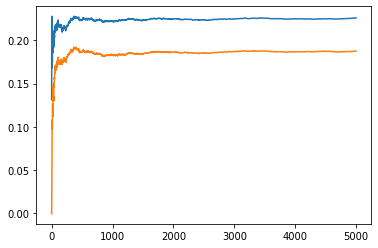

In [9]:
plt.plot(r.average_pseudo_regret())
plt.plot(r.average_regret())

In [10]:
class OptimalBandit(Bandit):
    
    def __init__(self, data):
        
        super().__init__(data)
    
    
    def initialize(self):
        """Choose each arm once to initialize estimates."""
        for arm in self.arms:
            context, gains = self.data.get(self.cur)
            chosen_arm, gain = self.choose(context, gains, arm=arm)
            self.save_history(gain, gains)
            self.update(chosen_arm, context, gain)
            
    
    def choose(self, context, gains, arm=None):
        """Choose action from context and history.
        
        If arm is None, then use strategy. 
        Else, force choice of specified arm.
        """
        if arm is None:
            arm = np.argmax(gains)
        return arm, gains[arm]
    
    
    def update(self, arm, context, gain):
        self.cur += 1

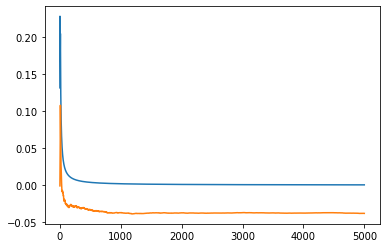

In [11]:
opt = OptimalBandit(d)
opt.run()
plt.plot(opt.average_pseudo_regret())
plt.plot(opt.average_regret())

Note: negative regret because uses contextual information.

In [12]:
# The staticbest strategy is equivalent to epsilon greedy with epsilon=0
class StaticBestBandit(Bandit):
    
    def __init__(self, data):
        
        super().__init__(data)

            
    def choose(self, context, gains, arm=None):
        """Choose action from context and history.
        
        If arm is None, then use strategy. 
        Else, force choice of specified arm.
        """
        if arm is None:
            arm = np.argmax(self.mu)
        self.mu += gains
        return arm, gains[arm]
    
    
    def update(self, arm, context, gain):
#         self.mu[arm] += (self.s[arm] * self.mu[arm] + gain) / (self.s[arm] + 1)
#         self.s[arm] += 1
        self.cur += 1

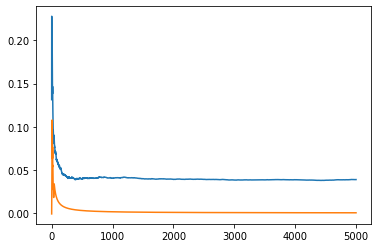

In [13]:
sb = StaticBestBandit(d)
sb.run()
plt.plot(sb.average_pseudo_regret())
plt.plot(sb.average_regret())

In [14]:
class EpsGreedyBandit(Bandit):
    
    def __init__(self, data, eps):
        
        super().__init__(data)
        self.eps=np.clip(eps, 0, 1)

            
    def choose(self, context, gains, arm=None):
        """Explore with probability self.eps, else greedy.
        
        If arm is None, then use strategy. 
        Else, force choice of specified arm.
        """
        if arm is None:
            if np.random.rand() < self.eps: # explore
                arm = np.random.choice(self.arms)
            else:
                arm = np.argmax(self.mu / self.s) # exploit
        return arm, gains[arm]
    
    
    def update(self, arm, context, gain):
        self.mu[arm] += (self.s[arm] * self.mu[arm] + gain) / (self.s[arm] + 1)
        self.s[arm] += 1
        self.cur += 1

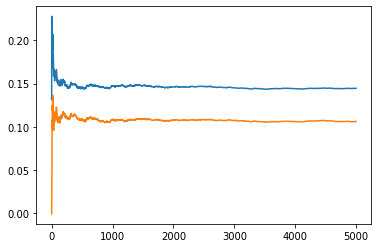

In [15]:
eg = EpsGreedyBandit(d, 0.5)
eg.run()
plt.plot(eg.average_pseudo_regret())
plt.plot(eg.average_regret())

In [16]:
class UCBBandit(Bandit):
    
    def __init__(self, data):
        
        super().__init__(data)



    def choose(self, c, g, best, it, arm=None):
        if not arm:
            bound = self.mu / self.s + np.sqrt(2*np.log(it) / self.s)
            arm = np.argmax(bound)
        return arm, g[arm], best
    

    def choose(self, context, gains, arm=None):
        """Explore with probability self.eps, else greedy.
        
        If arm is None, then use strategy. 
        Else, force choice of specified arm.
        """
        if arm is None:
            bound = self.mu / self.s + np.sqrt(2*np.log(self.cur) / self.s)
            arm = np.argmax(bound)
        return arm, gains[arm]
    
    
    def update(self, arm, context, gain):
        self.mu[arm] += (self.s[arm] * self.mu[arm] + gain) / (self.s[arm] + 1)
        self.s[arm] += 1
        self.cur += 1 

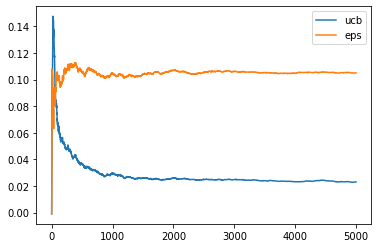

In [17]:
ucb = UCBBandit(d)
ucb.run()
# plt.plot(ucb.pseudo_regret())
plt.plot(ucb.average_regret(), label="ucb")
eg = EpsGreedyBandit(d, 0.5)
eg.run()
# plt.plot(eg.pseudo_regret())
plt.plot(eg.average_regret(), label="eps")
plt.legend()

In [18]:
class UCBLinBandit(Bandit):
    
    def __init__(self, data, delta):
        
        super().__init__(data)
        
        self.A = np.zeros((self.N_arms, data.d, data.d))
        for arm in self.arms:
            self.A[arm] = np.eye(data.d)
            
        self.b = np.zeros((self.N_arms, data.d))
                          
        self.delta = delta
        self.alpha = 1 + np.sqrt(np.log(2 / self.delta) / 2)
        
        
    def choose(self, context, gains, arm=None):
        """Explore with probability self.eps, else greedy.
        
        If arm is None, then use strategy. 
        Else, force choice of specified arm.
        """
        if arm is None:
            p = np.zeros(self.arms.size)
            for arm in self.arms:
                A_inv = np.linalg.inv(self.A[arm])
                theta = A_inv.dot(self.b[arm])
                p[arm] = theta.dot(context) + self.alpha * np.sqrt(context.dot(A_inv).dot(context))
            arm = np.argmax(p)
        return arm, gains[arm]
    
    
    def update(self, arm, context, gain):
        self.mu[arm] += (self.s[arm] * self.mu[arm] + gain) / (self.s[arm] + 1)
        self.s[arm] += 1
        self.cur += 1 
        self.A[arm] = self.A[arm] + np.outer(context, context)
        self.b[arm] = self.b[arm] + gain * context

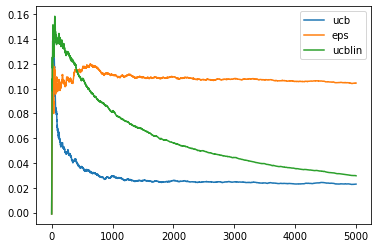

In [19]:
ucbLin = UCBLinBandit(d, 0.5)
ucbLin.run()
ucb = UCBBandit(d)
ucb.run()
plt.plot(ucb.average_regret(), label="ucb")
eg = EpsGreedyBandit(d, 0.5)
eg.run()
plt.plot(eg.average_regret(), label="eps")
plt.plot(ucbLin.average_regret(), label="ucblin")
plt.legend()

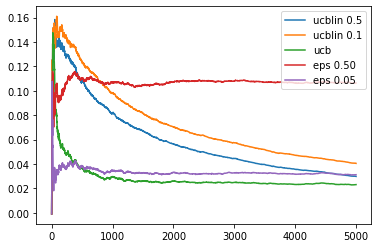

In [20]:
eg05 = EpsGreedyBandit(d, 0.05)
eg05.run()
eg50 = EpsGreedyBandit(d, 0.5)
eg50.run()
ucb = UCBBandit(d)
ucb.run()
ucbLin50 = UCBLinBandit(d, 0.5)
ucbLin50.run()
ucbLin10 = UCBLinBandit(d, 0.1)
ucbLin10.run()

plt.plot(ucbLin50.average_regret(), label="ucblin 0.5")
plt.plot(ucbLin10.average_regret(), label="ucblin 0.1")
plt.plot(ucb.average_regret(), label="ucb")
plt.plot(eg50.average_regret(), label="eps 0.50")
plt.plot(eg05.average_regret(), label="eps 0.05")

plt.legend()

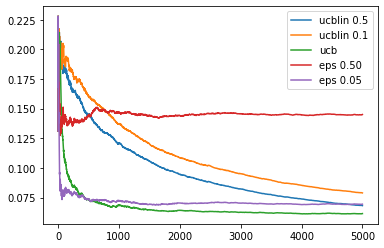

In [21]:
eg05 = EpsGreedyBandit(d, 0.05)
eg05.run()
eg50 = EpsGreedyBandit(d, 0.5)
eg50.run()
ucb = UCBBandit(d)
ucb.run()
ucbLin50 = UCBLinBandit(d, 0.5)
ucbLin50.run()
ucbLin10 = UCBLinBandit(d, 0.1)
ucbLin10.run()

plt.plot(ucbLin50.average_pseudo_regret(), label="ucblin 0.5")
plt.plot(ucbLin10.average_pseudo_regret(), label="ucblin 0.1")
plt.plot(ucb.average_pseudo_regret(), label="ucb")
plt.plot(eg50.average_pseudo_regret(), label="eps 0.50")
plt.plot(eg05.average_pseudo_regret(), label="eps 0.05")

plt.legend()

## Interpretation

We see that UCB, Epsilon greedy (0.05) and UCB Linear seem to attain the same asymptotic average regret (and pseudo-regret). UCB Linear is slower to converge than Linear: it is not as sample efficient with this dataset.